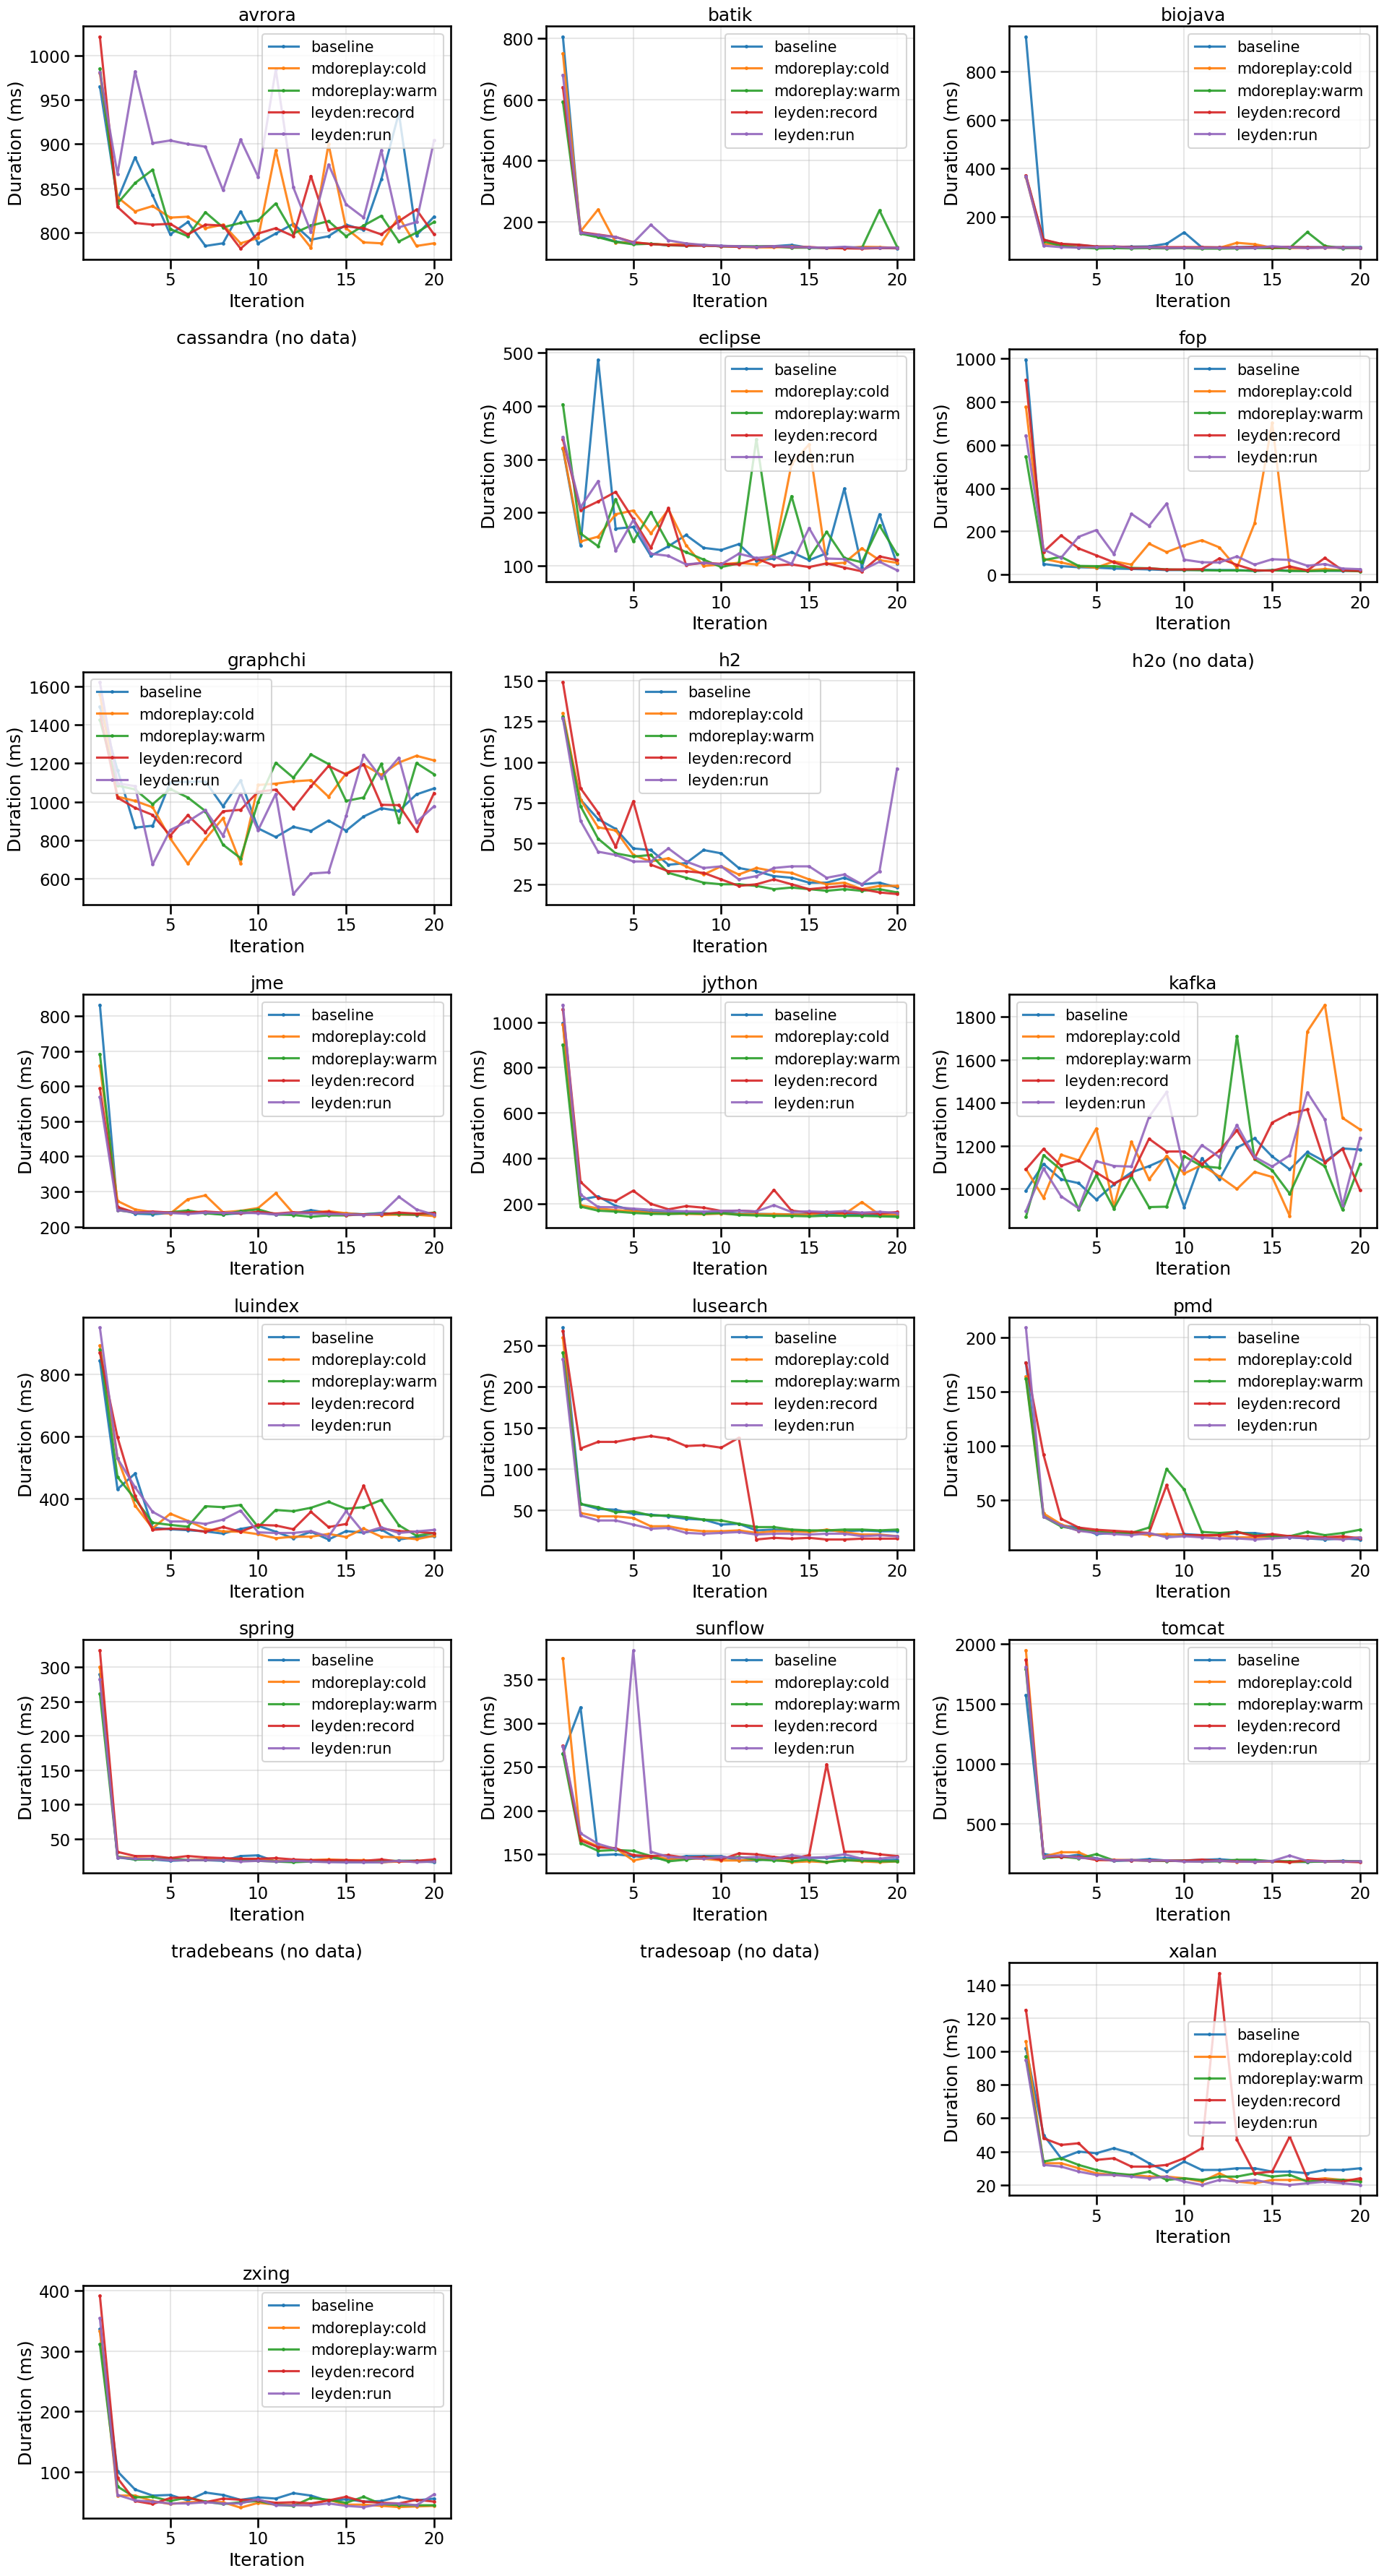

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')

# Root where run_all.py wrote results
out_root = Path('/Users/georgezhou/personal/research/serverless-jit/bench/dacapo/out')
if not out_root.exists():
    raise FileNotFoundError(f'Missing output directory: {out_root}')

# Collect benches (ignore stray files)
benches = sorted([p.name for p in out_root.iterdir() if p.is_dir()])

# Desired line order per plot
series_order = [
    ('baseline', 'run'),
    ('mdoreplay', 'cold_dump'),
    ('mdoreplay', 'warm_load'),
    ('leyden', 'record'),
    ('leyden', 'run'),
]
label_map = {
    ('baseline', 'run'): 'baseline',
    ('mdoreplay', 'cold_dump'): 'mdoreplay:cold',
    ('mdoreplay', 'warm_load'): 'mdoreplay:warm',
    ('leyden', 'record'): 'leyden:record',
    ('leyden', 'run'): 'leyden:run',
}

# Helper to load and aggregate one bench
def load_bench_df(bench: str) -> pd.DataFrame:
    bdir = out_root / bench
    frames = []
    for wf in ['baseline', 'mdoreplay', 'leyden']:
        f = bdir / f'{wf}.csv'
        if not f.exists():
            continue
        try:
            df = pd.read_csv(f)
        except Exception:
            continue
        # Normalize required columns and types
        required_cols = {'suite','bench','workflow','phase','repeat','iteration','duration_ms'}
        if not required_cols.issubset(set(df.columns)):
            continue
        df = df[['suite','bench','workflow','phase','repeat','iteration','duration_ms']].copy()
        # Normalize workflow naming: run.sh uses "default" for baseline
        df['workflow'] = df['workflow'].replace({'default': 'baseline'})
        # Average repeats to a single line per (workflow, phase)
        df = (
            df.groupby(['bench','workflow','phase','iteration'], as_index=False)['duration_ms']
              .mean()
        )
        frames.append(df)
    if not frames:
        return pd.DataFrame(columns=['bench','workflow','phase','iteration','duration_ms'])
    return pd.concat(frames, ignore_index=True)

# Load all
per_bench = {b: load_bench_df(b) for b in benches}

# Plot: one subplot per bench, up to 3 columns
n = len(benches)
if n == 0:
    raise RuntimeError('No benchmark subdirectories found under out/.')
cols = 3
rows = int(np.ceil(n / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*6.5, rows*4.5), squeeze=False, sharex=False)

for idx, bench in enumerate(benches):
    ax = axes[idx // cols][idx % cols]
    dfb = per_bench.get(bench)
    if dfb is None or dfb.empty:
        ax.set_title(f'{bench} (no data)')
        ax.axis('off')
        continue
    plotted = False
    for key in series_order:
        sub = dfb[(dfb['workflow'] == key[0]) & (dfb['phase'] == key[1])]
        if sub.empty:
            continue
        ax.plot(sub['iteration'], sub['duration_ms'], marker='o', ms=2.5, label=label_map[key], alpha=0.9)
        plotted = True
    ax.set_title(bench)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Duration (ms)')
    ax.grid(True, alpha=0.3)
    if plotted:
        ax.legend(fontsize='small')
    else:
        ax.text(0.5, 0.5, 'no series', ha='center', va='center', transform=ax.transAxes)

# Hide any unused axes
for j in range(n, rows*cols):
    fig.delaxes(axes[j // cols][j % cols])

plt.tight_layout()
plt.show()
